#  Iris Data Set 
https://en.wikipedia.org/wiki/Iris_flower_data_set

### Informazioni sul data set:

Questo data set contiene 150 record riguardanti la lunghezza, larghezza dei petali e sepali di 3 diversi tipi di iris (Setosa, Versicolour, and Virginica).

Le colonne sono definite da: Sepal Length (cm), Sepal Width (cm), Petal Length (cm) e Petal Width (cm).

In [254]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()

X = iris.data
y = iris.target

df = pd.DataFrame(X)
df.columns = iris['feature_names']

le = LabelEncoder()
le.fit(iris.target_names)
df['type'] = le.inverse_transform(y)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),type
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Osserviamo prima i dati

#### Perchè è importante osservare prima i dati?
Osservare i dati potrebbe essere utile per diversi motivi, dobbiamo capire se serve o meno fare pre-processing su di essi. Il pre-processing consiste nella pre-elaborazione dei dati prima di passarli al nostro modello, nel nostro caso un multilayer perceptron.

- Potrebbe servirci a vedere se abbiamo degli outlier (ad esempio dati da un errore umano nel prendere i dati, se avessimo un petalo lungo 4 metri tra i nostri dati potremmo accorgerci che c'è qualcosa che non va). Questi outlier, che siano errori umani o no, potrebbero compromettere l'apprendimento della nostra rete neurale. In questi casi è cosa buona e giusta eliminare quei dati (se errati) e se possibile imputarli, o standardizzarli.


- Se tra le nostre feature abbiamo distrubuzioni troppo diverse (ad esempio una feature si distribuisce tra 0 e 1 mentre un'altra ha valori tra 0 e 10M, quest'ultima avrà un'influenza maggiore nell'apprendimento della nostra rete neurale, cosa che potremmo non desiderare. In questo caso potrebbe essere utile normalizzare i nostri dati.

### Box plot

Proviamo ad osservare i nostri dati con un box plot, in questo modo abbiamo una buona visualizzazione della loro distribuzione e siamo capaci di vedere se abbiamo outlier, che come abbiamo visto potrebbero risultare un po' fastidiosi per la nostra rete neurale. Per fortuna sembrano non esserci, e inoltre i dati si distribuiscono in un range abbastanza simile, in questo caso non abbiamo bisogno di normalizzare i dati. 

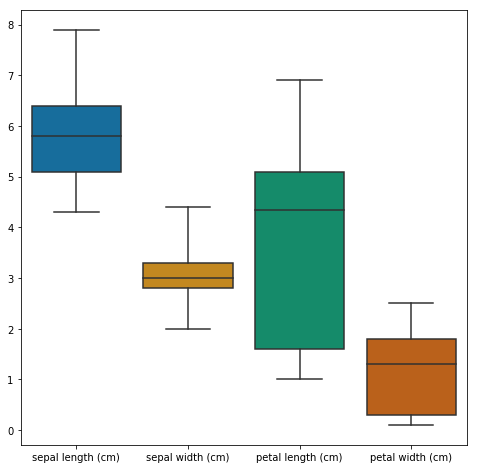

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
sns.boxplot(data=df.iloc[:,:-1], palette='colorblind', orient='v', whis='range')
plt.show()

## Feature selection 
Un altro passo importante del pre-processing dei nostri dati è la feature selection. Consiste nel selezionare gli attributi che possono rendere più accurata la nostra rete neurale e scartare quelli irrilevanti che possono diminuirne l'accuratezza.

Esistono diversi modi per fare la feature selection, essendo questo un data set con solo 4 colonne c'è poco da selezionare, ma controlliamo la correlazione tra le feature per vedere che relazione hanno tra di loro. Controllare la correlazione potrebbe farci capire se: 

- Uno o più attributi dipendono da un'altro attributo.
- Uno o più attributi sono associati ad altri attributi.

#### Ma perchè ci torna utile? 
- La correlazione ci può aiutare a predire un attributo da un altro (ottimo modo per imputare valori mancanti o errati).
- La correlazione ci può *(a volte)* indicare la presenza di relazioni di causa.

https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4

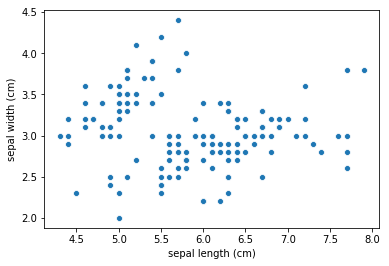

In [5]:
sns.scatterplot("sepal length (cm)", "sepal width (cm)", data=df)
plt.show()

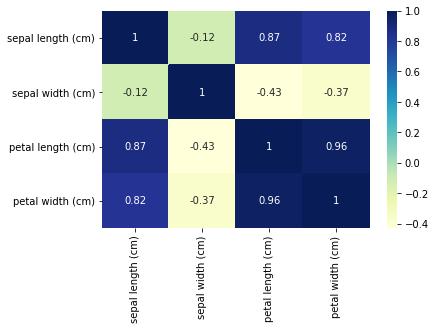

In [4]:
sns.heatmap(df[df.columns[:-1]].corr(), annot = True, cmap="YlGnBu")
plt.show()

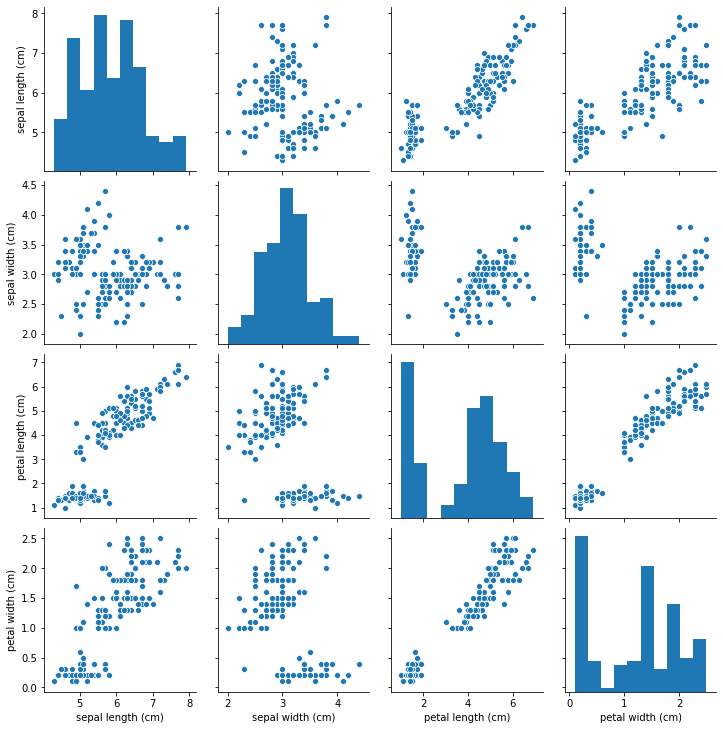

In [5]:
sns.pairplot(df, x_vars=df.columns[:-1], y_vars=df.columns[:-1])
plt.show()

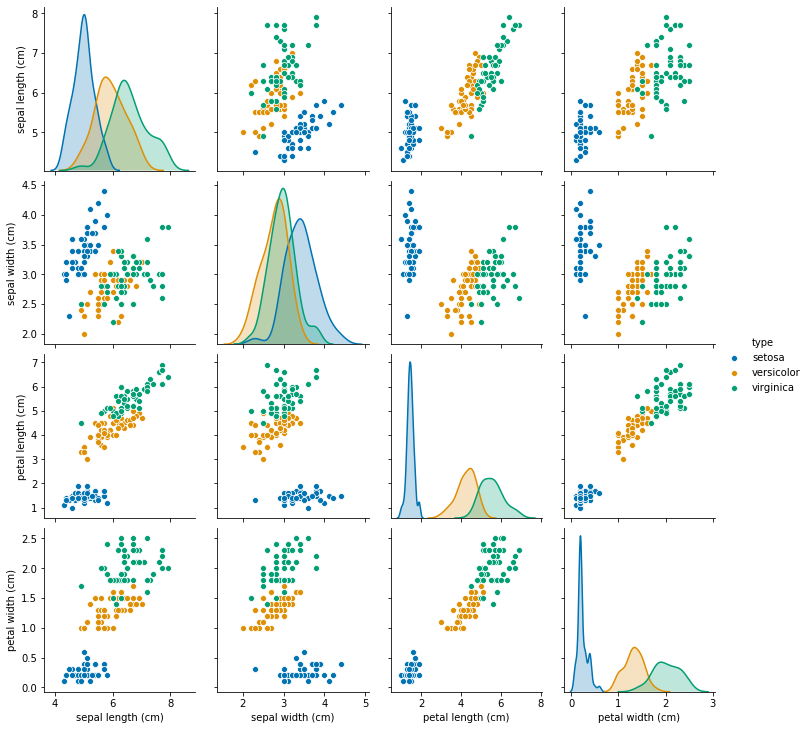

In [6]:
sns.pairplot(df, palette="colorblind", hue='type', x_vars=df.columns[:-1], y_vars=df.columns[:-1])
plt.show()

### KDEplot: Kernel density estimation

Non è altro che la funzione di densità che già conosciamo, solo in questo caso, su due dimensioni. Più cerchi ci sono intorno ad un'area, più è probabile che ci siano presenti dei dati. 

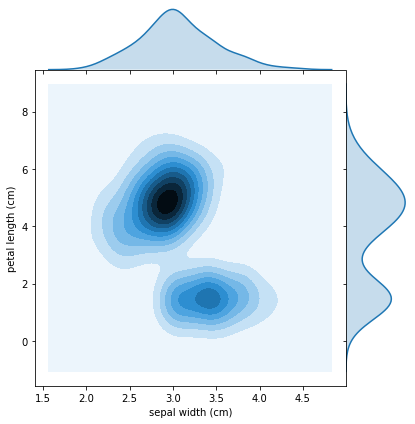

In [7]:
sns.jointplot("sepal width (cm)", "petal length (cm)", data=df, kind="kde", space=0)
plt.show()

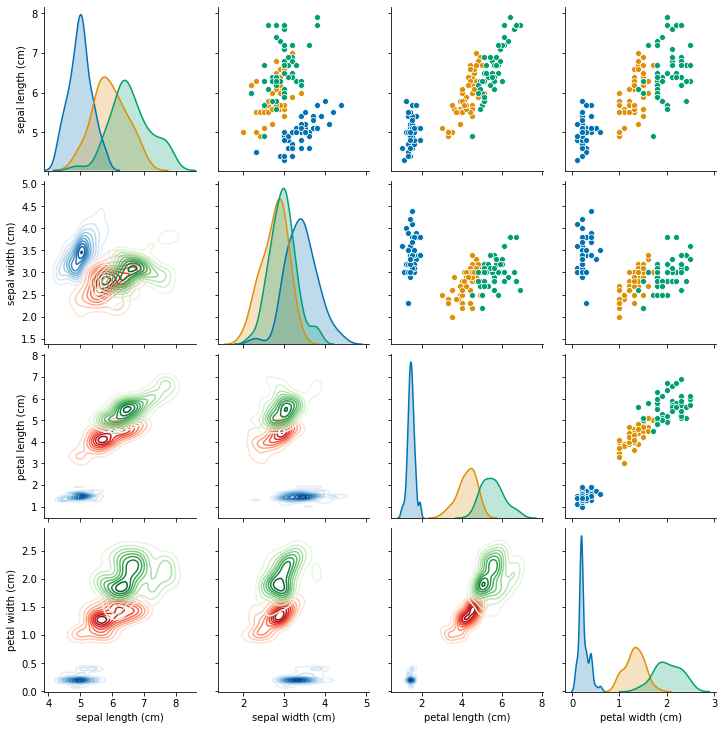

In [8]:
g = sns.PairGrid(df, hue="type", hue_kws={"cmap": ["Blues", "Reds", "Greens"]}, palette="colorblind", diag_sharey=False)

g = g.map_diag(sns.kdeplot, shade=True)
g = g.map_lower(sns.kdeplot, shade_lowest=False)
g = g.map_upper(sns.scatterplot)

In [9]:
import matplotlib.patheffects as PathEffects

def scatter(x, labels, names):
    palette = np.array(sns.color_palette("colorblind", 3))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot()
    sc = ax.scatter(x[:,0], x[:,1], c=palette[list(labels)], alpha=0.7)
    
    ax.axis('off')

    txts = []
    for i in range(len(names)):
        # Ogni label viene posta nella mediana dei punti corrispondenti.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(names[i]), fontsize=18)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    
    return f, ax, sc, txts

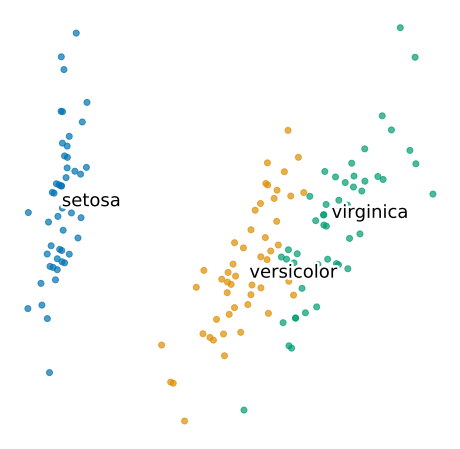

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig_pca, ax_pca, _, _ = scatter(X_pca, y.astype(int), iris.target_names)
plt.show()

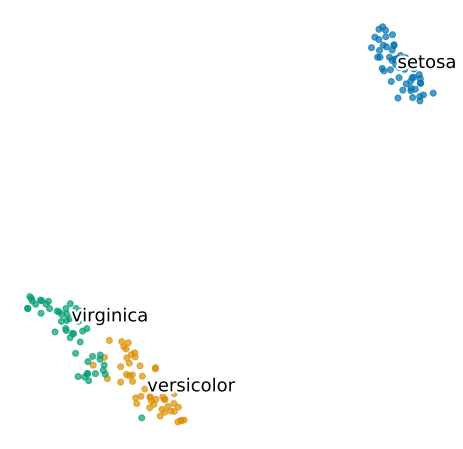

In [11]:
from sklearn.manifold import TSNE

X_tsne = TSNE().fit_transform(X)

fig_tsne, ax_tsne, _, _ = scatter(X_tsne, y.astype(int), iris.target_names)
plt.show()

# Passiamo alla rete neurale... Ma da dove partiamo?

La scelta degli iperparametri di una rete neurale è un po' un'arte, se non abbiamo idea di dove mettere le mani potremmo avere risultati abbastanza tristi.

In [257]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y)

nn = MLPClassifier(activation='logistic', hidden_layer_sizes=(2), learning_rate_init=0.5, max_iter=500)

nn.fit(X_train, y_train)

print("Accuracy: %0.2f" % nn.score(X_test, y_test))

Accuracy: 0.29


Andiamo a vedere che cos'ha sbagliato la nostra rete neurale. Caspita! Ha classificato tutti i fiori del training con label 2, secondo la nostra rete neurale sono tutti iris virginica!

In [223]:
nn.predict(X_test)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Queste erano le classificazioni ci aspettavamo di ricevere.

In [224]:
y_test

array([1, 1, 0, 0, 0, 2, 1, 0, 2, 1, 0, 0, 2, 1, 1, 2, 2, 1, 2, 0, 1, 0,
       2, 1, 2, 2, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 2, 1])

# Model selection 

Come possiamo fare? Una prima idea potrebbe essere quella di definire degli insiemi di parametri da voler provare e iterativamente, provare tutte le combinazioni.

Proviamo con i parametri
- hidden_layer_sizes = [(10,2), (10), (5,5)]
- learning_rate_init = [0.2, 0.1, 0.01]

e plottiamo le accuracy per ogni epoca delle reti neurali che testiamo. Come possiamo vedere dal grafico, ci sono delle reti neurali che hanno avuto la meglio sulla nostra prima implementazione.

Diciamoci però che il grafico non è prorio bellissimo, inoltre non sappiamo quali siano gli iperparametri delle curve plottate.

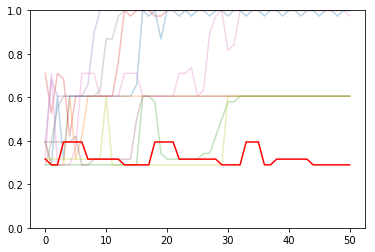

In [261]:
nn = MLPClassifier(activation='logistic', hidden_layer_sizes=(2), learning_rate_init=0.5, max_iter=500)

hidden_layer_sizes = [(10,2), (10), (5,5)]
learning_rate_init = [0.2, 0.1, 0.01]

classifiers = []

for layers in hidden_layer_sizes:
    for lri in learning_rate_init: 
        classifiers.append(("HL: {} | LRI: {}".format(layers,lri), MLPClassifier(activation='logistic', hidden_layer_sizes=layers, 
                                         learning_rate_init=lri, max_iter=500)))

        
N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 51
N_CLASSES = np.unique(y_train)

scores = []
my_nn_scores = []

num = 0
for name, clf in classifiers:
    epoch = 0
    clf_scores = []
    for epoch in range(N_EPOCHS):
        nn.partial_fit(X_train, y_train, classes=N_CLASSES)
        
        clf.partial_fit(X_train, y_train, classes=N_CLASSES)
        
        clf_scores.append(clf.score(X_test, y_test))
        
        if num == 0:
            my_nn_scores.append(nn.score(X_test, y_test))
        
    num+=1
    scores.append((name, clf_scores))

    
for name, score in scores:
    plt.plot(score, alpha=0.3)

plt.plot(my_nn_scores, color="red")
plt.ylim(0,1)
plt.show()

Proviamo ad usare gli small multiples per vedere le accuracy e per ogni subplot, aggiungiamo l'informazione relativa agli iperparametri della rete neurale associata. 

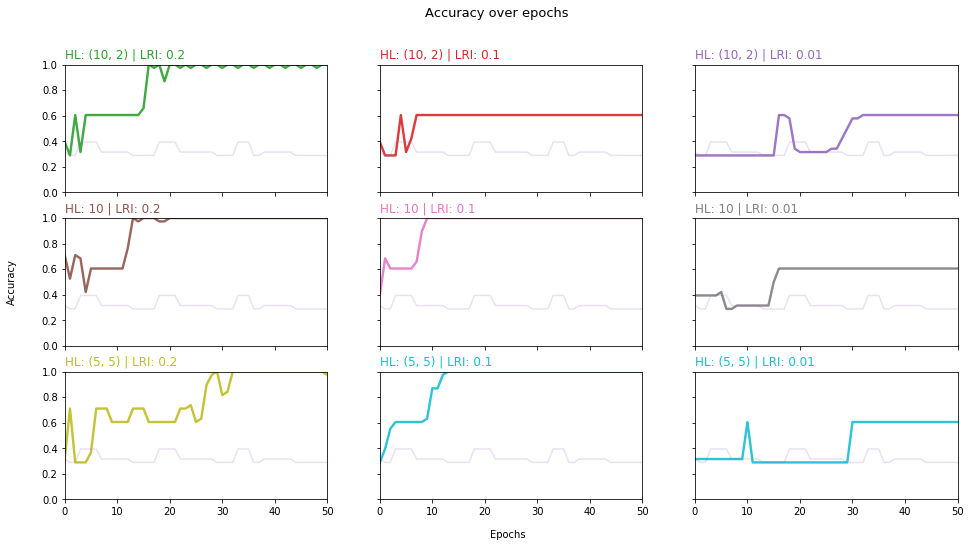

In [264]:
plt.figure(figsize=(16,8))
palette = plt.get_cmap('tab10')
 
num=0

for name, score in scores:
    num+=1
 
    plt.subplot(3,3, num)

            
    plt.plot(score, marker='', color=palette(num+1), linewidth=2.4, alpha=0.9)
    
    
    plt.plot(my_nn_scores, color=palette(4), alpha=0.2)

 
    plt.xlim(0,N_EPOCHS-1)
    plt.ylim(0,1)
 
    if num in range(7) :
        plt.tick_params(labelbottom=False)
    if num not in [1,4,7] :
        plt.tick_params(labelleft=False)
        
    plt.title(name, loc='left', fontsize=12, fontweight=0, color=palette(num+1) )
    
plt.suptitle("Accuracy over epochs", fontsize=13, fontweight=0, color='black')
 
plt.text(-39, -0.3, 'Epochs')
plt.text(-130, 1.7, 'Accuracy', ha='center', va='center', rotation='vertical')
plt.show()

Molto meglio! Volendo possiamo anche sottrarre le due funzioni e vedere quando una è meglio dell'altra. 

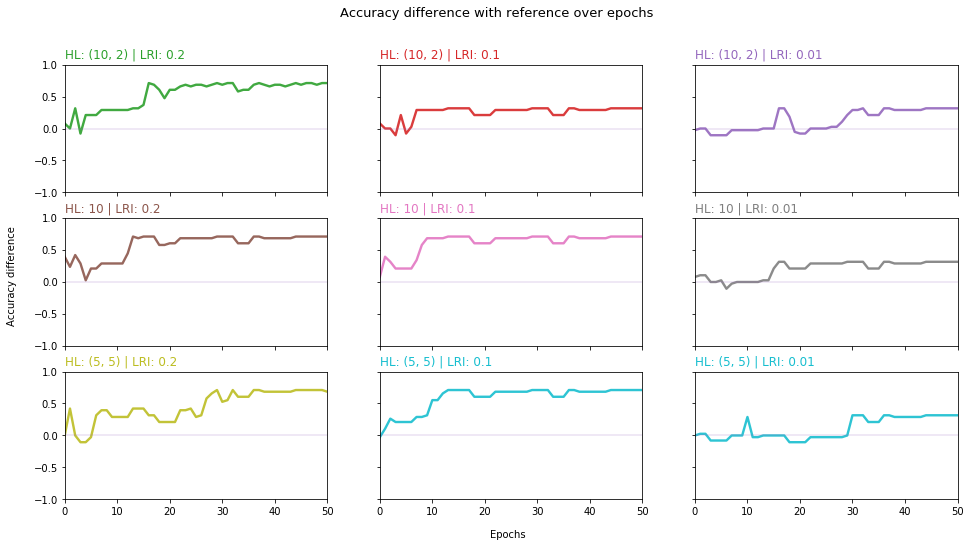

In [263]:
plt.figure(figsize=(16,8))
palette = plt.get_cmap('tab10')
 
my_nn_scores = np.array(my_nn_scores)

num=0

for name, score in scores:
    num+=1
    
    score_test = np.array(score)
    
    plt.subplot(3,3, num)

            
    plt.plot(score-my_nn_scores, marker='', color=palette(num+1), linewidth=2.4, alpha=0.9)
    
    
    plt.plot(my_nn_scores - my_nn_scores, color=palette(4), alpha=0.2)

 
    plt.xlim(0,N_EPOCHS-1)
    plt.ylim(-1,1)
 
    if num in range(7) :
        plt.tick_params(labelbottom=False)
    if num not in [1,4,7] :
        plt.tick_params(labelleft=False)
        
    plt.title(name, loc='left', fontsize=12, fontweight=0, color=palette(num+1) )
    
plt.suptitle("Accuracy difference with reference over epochs", fontsize=13, fontweight=0, color='black')
 
plt.text(-39, -1.6, 'Epochs')
plt.text(-130, 2.5, 'Accuracy difference', ha='center', va='center', rotation='vertical')
plt.show()

Ok, come è facile immaginare in python esistono dei tool che semplificano la model selection. Prima di mostrarlo però, vale la pena spiegare un ultimo concetto fondamentale: la cross validation.

In [265]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

params = {
    'hidden_layer_sizes': [(10,2), (10), (5,5)],
    'learning_rate_init' : [0.2, 0.1, 0.01,]
}

mlp = MLPClassifier(activation='logistic', max_iter=10000, learning_rate='adaptive')

gs = GridSearchCV(mlp, params, n_jobs=-1, cv=5, return_train_score=True)

gs.fit(X,y)

print("Best estimator: %s\n\nBest estimator's accuracy: %0.2f" % (gs.best_estimator_, gs.best_score_))

Best estimator: MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 2), learning_rate='adaptive',
       learning_rate_init=0.2, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

Best estimator's accuracy: 0.99
